#### try only genotype for early screening with feature selection (using threshold)

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold

In [2]:
# for SNP model (1e-6)
df_case = pd.read_csv('../datasets/final_6p/filtered_ensnp_case.csv',index_col=0)
df_control = pd.read_csv('../datasets/final_6p/filtered_ensnp_control.csv',index_col=0)
df_case = df_case.reset_index(drop=True)
df_control = df_control.reset_index(drop=True)

# data preparing
case_cohort = df_case.astype('float32')
control_cohort = df_control.astype('float32')

case_cohort.insert(case_cohort.shape[1], 'label', 1)
control_cohort.insert(control_cohort.shape[1], 'label', 0)
merged = pd.concat([case_cohort, control_cohort])
merged = merged.fillna(0)
merged

,smoking status,sleep duration,sleeplessness,coffee intake,tea intake,alcohol intake frequency,salad/raw vegetable intake,fresh fruit intake,cooked vegetable intake,pork intake,...,rs4806664A2,rs34563859A1,rs34563859A2,rs12459907A1,rs12459907A2,rs557652995A1,rs557652995A2,rs200896099A1,rs200896099A2,label
0,0.0,9.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
1,0.0,7.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1
2,0.0,6.0,0.0,2.0,4.0,0.0,0.0,3.0,3.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1
3,1.0,7.0,1.0,3.0,7.0,0.0,1.0,2.0,2.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1
4,0.0,8.0,0.0,5.0,0.0,0.0,2.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3284,0.0,7.0,0.0,2.0,6.0,0.0,1.0,1.0,2.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0
3285,0.0,7.0,0.0,1.0,1.0,0.0,2.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
3286,0.0,8.0,0.0,2.0,0.0,1.0,1.0,1.0,3.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0
3287,0.0,7.0,0.0,3.0,2.0,1.0,1.0,5.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0


In [3]:
merged = merged.drop(merged.columns[0:18],axis=1)
merged

,rs185601219A1,rs185601219A2,rs560692838A1,rs560692838A2,rs563775604A1,rs563775604A2,rs542929480A1,rs542929480A2,3_34292328_TTA_TA1,3_34292328_TTA_TA2,...,rs4806664A2,rs34563859A1,rs34563859A2,rs12459907A1,rs12459907A2,rs557652995A1,rs557652995A2,rs200896099A1,rs200896099A2,label
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3284,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0
3285,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
3286,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0
3287,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0


In [4]:
# shuffle and split dataset

#dropped = merged.drop('eid',axis=1)
shuffled = shuffle(merged)
train_data = shuffled[0:int(shuffled.shape[0]*0.9)]
test_data = shuffled[int(shuffled.shape[0]*0.9):]
print(train_data.shape[0])
print(test_data.shape[0])

# fetch values
nor_feature_train = train_data.drop('label',axis=1)
X_train = nor_feature_train.values
nor_feature_test = test_data.drop('label',axis=1)
X_test = nor_feature_test.values
Y_train = train_data['label'].values
Y_test = test_data['label'].values

nor_feature = shuffled.drop('label',axis=1)
X = nor_feature.values
Y = shuffled['label'].values

5913
657


(mean) ACC:  0.5019786910197869 Precision:  0.5015553020034559 Recall:  0.4934650477064781 F1:  0.4973146313303854 AUC:  0.5041543012957287
(std) ACC:  0.012938490433700702 Precision:  0.01500151234270817 Recall:  0.015697553748785165 F1:  0.012380775168094922 AUC:  0.015376609723390939


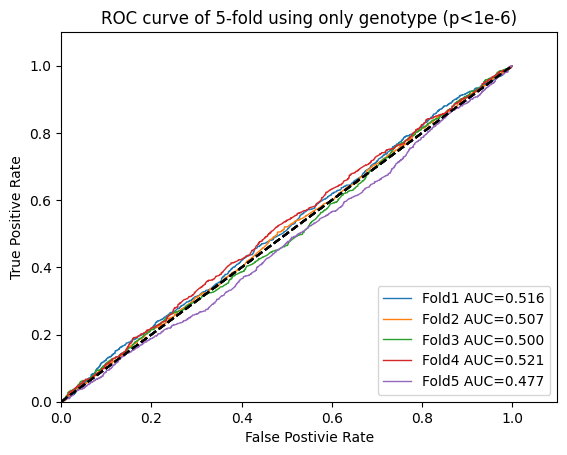

In [5]:
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    #clf = xgb.XGBClassifier(n_jobs=-1,n_estimators=15,max_depth=6)
    clf = xgb.XGBClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold using only genotype (p<1e-6)')
plt.savefig('../images/6p-ROC-onlySNP-5fold.png',dpi=300, bbox_inches = 'tight')
plt.show()

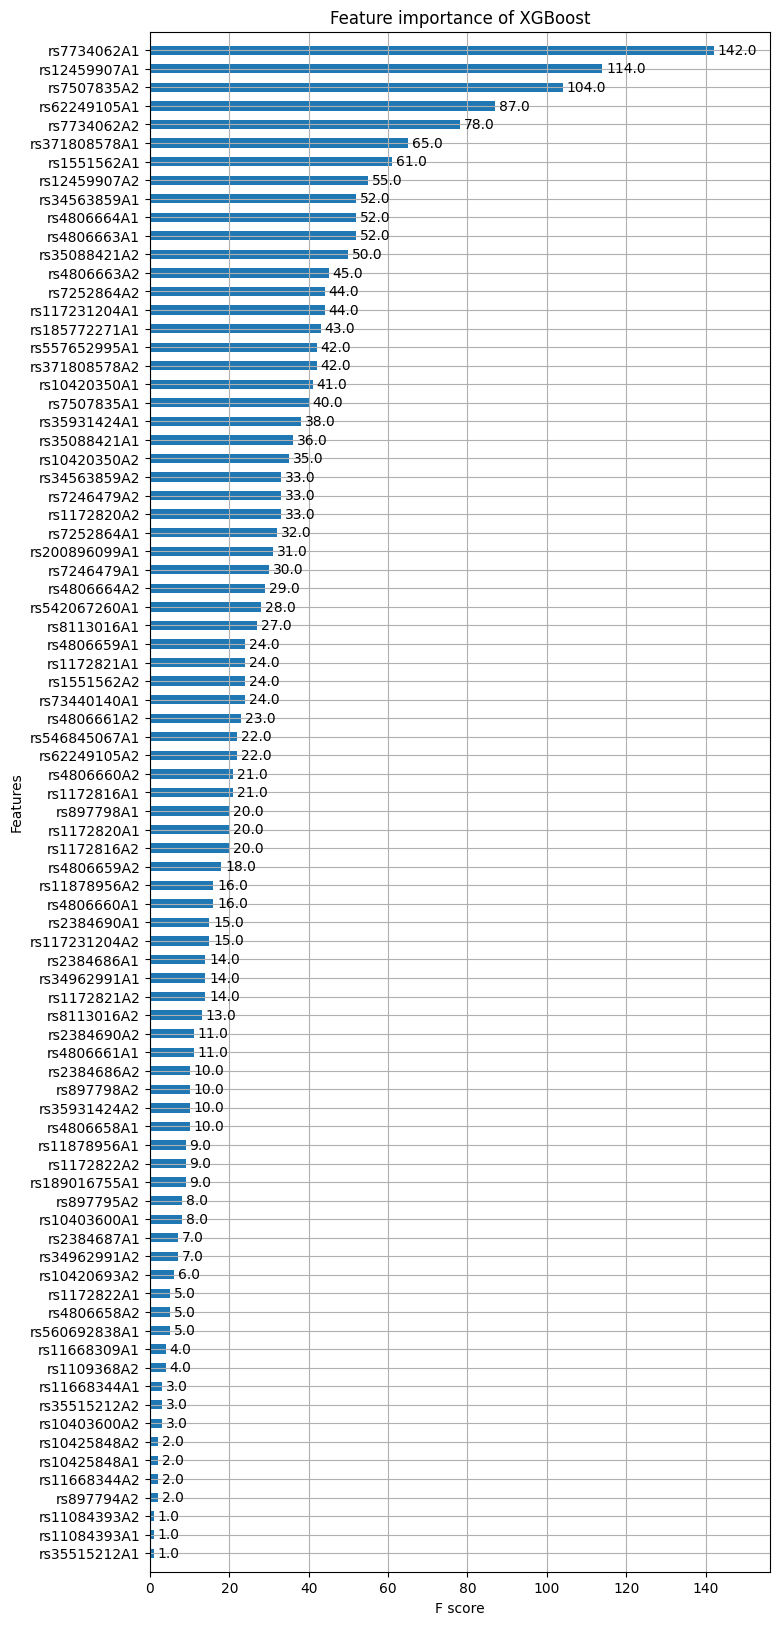

In [6]:
## feature importance
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import xgboost

clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X,Y)

# xgboost
fig,ax = plt.subplots(figsize=(8,20))
model_name='XGBoost'
feature_names = merged.drop(columns=['label']).columns.values.tolist()
clf_xgb.get_booster().feature_names = feature_names
xgboost.plot_importance(clf_xgb, ax=ax,height=0.5)
plt.title('Feature importance of '  + model_name)
plt.savefig('../images/6p-onlysnp_feature_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

In [7]:
# try high-rank SNPs
print(clf_xgb.feature_importances_)
print(max(clf_xgb.feature_importances_))

[0.         0.         0.02802994 0.         0.         0.
 0.         0.         0.         0.         0.01369458 0.01035291
 0.00179846 0.         0.         0.         0.         0.
 0.         0.         0.01496215 0.         0.         0.
 0.00426134 0.         0.01219841 0.01570074 0.         0.
 0.00321717 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01446128 0.00105517 0.00425681 0.         0.         0.
 0.01222409 0.01324257 0.         0.         0.         0.
 0.01314824 0.01757591 0.01313895 0.00806106 0.01308373 0.0194204
 0.01115155 0.01209968 0.         0.         0.0149587  0.00617142
 0.01199717 0.01118551 0.01324515 0.01408643 0.00833054 0.01444288
 0.01635042 0.00134013 0.01848902 0.0097808  0.0116594  0.01500175
 0.01423448 0.01189896 0.01745597 0.01270331 0.         0.
 0.00658632 0.013

In [8]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
selection = SelectFromModel(clf_xgb, threshold=0.05, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, Y_train)
# eval model
select_X_test = selection.transform(X_test)
#y_pred = selection_model.predict(select_X_test)

y_score = selection_model.predict(select_X_test)                                   
y_score_pro = selection_model.predict_proba(select_X_test) # (212, 2)
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('confusion_matrix\n', obj1)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)

ax = plt.figure(figsize=(3, 3))
plt.title('With genotype')
import seaborn as sns
sns.heatmap(new_obj, fmt='.2f', cmap='GnBu', annot=True)
plt.ylabel("true label")
plt.xlabel("predict label")
#plt.savefig('../images/cm-SNP.png',dpi=300, bbox_inches = 'tight')
plt.show()

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


XGBoostError: [21:21:31] C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:792: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?